In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import dates
from matplotlib import pyplot as plt
from sklearn import linear_model

plt.xkcd()

In [2]:
# Get some data (PA is the 5th table on the page)
df = pd.read_html(
    "https://alex.github.io/nyt-2020-election-scraper/battleground-state-changes.html",
    header=1,
)[5]

# Coerce to pandas Timestamp re-expressed in US/Eastern timezone
df.Timestamp = pd.to_datetime(df.Timestamp).dt.tz_convert("US/Eastern")

# Pennsylvania count data looks linear from 07:00 ET -> 12:00 UTC
df_today = df[df.Timestamp > "2020-11-05 07:00:00"]

# Model 'Vote Differential' ~ Timestamp (as epoch) using simple linear regression
X = df_today[["Timestamp"]].astype(int) / 1e9
y = df_today["Vote Differential"]
model = linear_model.LinearRegression().fit(X, y)

# If y = mx + c, then x = m/-c at y=0
datetime_at_zero = pd.to_datetime(model.intercept_ / -model.coef_[0], unit="s")
datetime_at_zero.strftime("%d %b %H:%M") + " US/Eastern"

'06 Nov 09:09 US/Eastern'

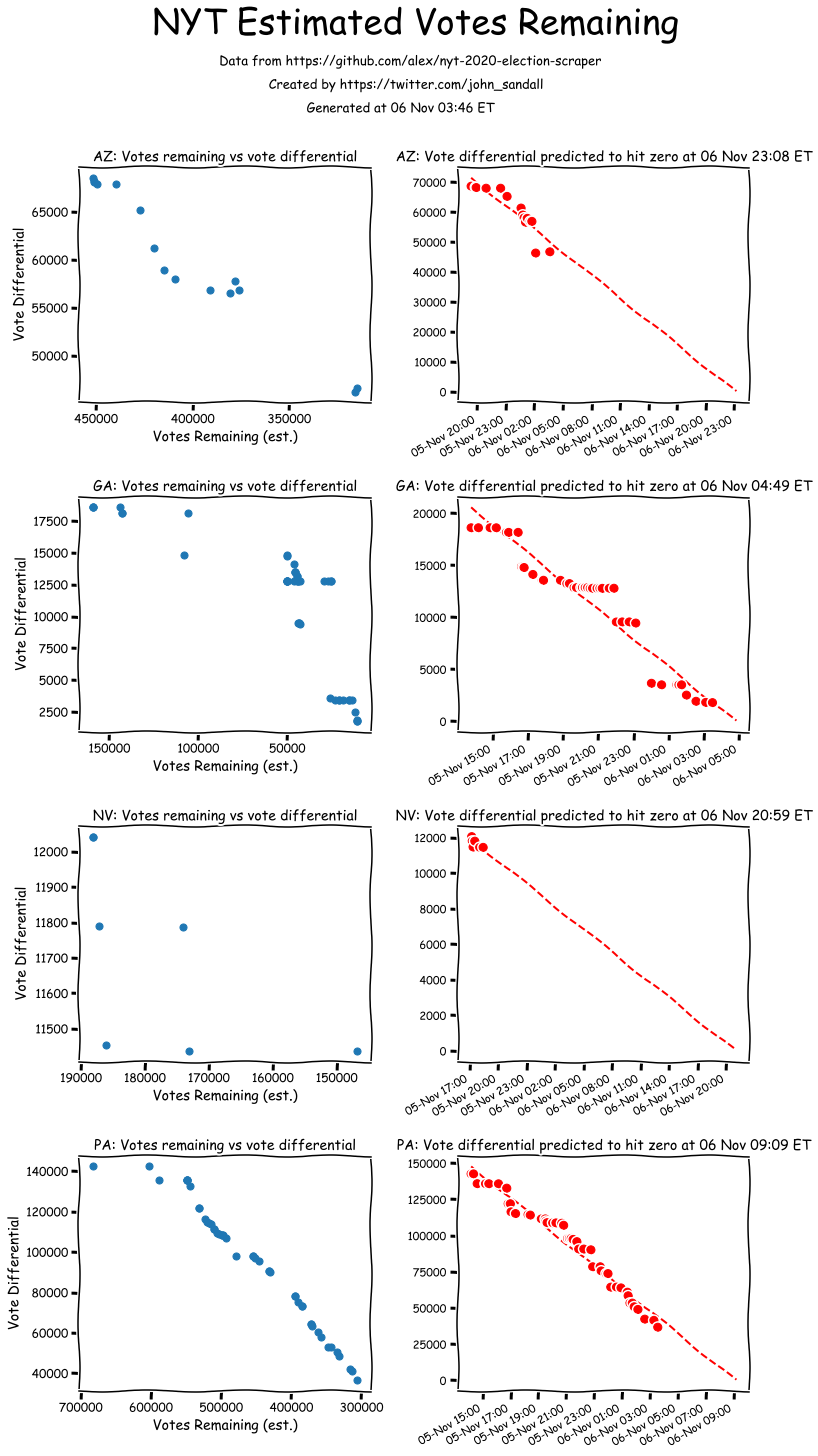

In [3]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12, 25))
fig.subplots_adjust(hspace=0.4, wspace=0.3)
plt.rcParams.update({"axes.titlesize": "medium"})

dfs = dict(
    zip(
        ["AK", "AZ", "GA", "NC", "NV", "PA"],
        pd.read_html(
            "https://alex.github.io/nyt-2020-election-scraper/battleground-state-changes.html"
        ),
    )
)

# AK hasn't changed for 24hrs and NC vote diff is static
del dfs["AK"]
del dfs["NC"]

for i, (state, df) in enumerate(dfs.items()):
    # Remove hierarchical index
    df.columns = df.columns.get_level_values(1)

    # Coerce to pandas Timestamp re-expressed in US/Eastern timezone
    df.Timestamp = pd.to_datetime(df.Timestamp).dt.tz_convert("US/Eastern")

    # Select 07:00 ET onwards (12:00 UTC)
    df_today = df[df.Timestamp > "2020-11-05 07:00:00"]

    # Plot votes remaining vs vote differential
    df_today.plot(
        x="Votes Remaining (est.)",
        y="Vote Differential",
        kind="scatter",
        s=50,
        fontsize=12,
        title=f"{state}: Votes remaining vs vote differential",
        ax=ax[i][0],
    ).invert_xaxis()

    # Model 'Vote Differential' ~ Timestamp (as epoch) using simple linear regression
    X = df_today[["Timestamp"]].astype(int) / 1e9
    y = df_today["Vote Differential"]
    model = linear_model.LinearRegression().fit(X, y)

    # If y = mx + c, then x = m/-c at y=0
    datetime_at_zero = pd.to_datetime(model.intercept_ / -model.coef_[0], unit="s")

    # Let's add the linear regression lines!
    x0 = df_today.Timestamp.iloc[-1]
    y0 = model.predict(X.tail(1))[0]
    x1 = datetime_at_zero.tz_localize("UTC").tz_convert("US/Eastern")
    y1 = 0
    regression_line = pd.DataFrame({"x": [x0, x1], "y": [y0, y1]})
    regression_line.set_index("x").y.plot(color="red", style="--", ax=ax[i][1])

    # Plot vote differential vs time (overall, and for today)
    formatter = dates.DateFormatter("%d-%b %H:%M")
    ax[i][1].xaxis.set_major_formatter(formatter)
    df_today.set_index("Timestamp")["Vote Differential"].plot(
        style=".",
        markersize=15,
        color="red",
        fontsize=11,
        title=f"{state}: Vote differential predicted to hit zero at {datetime_at_zero.strftime('%d %b %H:%M')} ET",
        ax=ax[i][1],
    )
    # Hide "Datetime", it's obvious what the x-axis represents
    ax[i][1].xaxis.set_label_text("")

# Wrap up
def add_text(text, coords, fontsize):
    plt.annotate(
        text,
        coords,
        (0, 0),
        fontsize=fontsize,
        fontweight=200,
        xycoords="axes fraction",
        textcoords="offset points",
        va="top",
    )


add_text("NYT Estimated Votes Remaining", (-1.05, 5.88), fontsize=35)
add_text(
    "Data from https://github.com/alex/nyt-2020-election-scraper",
    (-0.82, 5.68),
    fontsize=13,
)
add_text("Created by https://twitter.com/john_sandall", (-0.65, 5.58), fontsize=13)
add_text(
    f"Generated at {pd.Timestamp.now().strftime('%d %b %H:%M')} ET",
    (-0.52, 5.48),
    fontsize=13,
)